In [61]:
import os
import torch
import numpy as np
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as T
import torch.nn.functional as F

from ig_pkg.datasets import get_datasets

from ig_pkg.models.generator import get_model
from ig_pkg.models.classifier import get_classifier
from ig_pkg.models.pretrained_models import get_pretrained_model

from ig_pkg.inputattribs.ig import ig
from ig_pkg.inputattribs.baseline_generator import get_baseline_generator

from ig_pkg.misc import process_heatmap, normalize_tensor, convert_to_img, label_to_class, tran, na_imshow

import time
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from ig_pkg.loss.focal_loss import FocalLoss
from ig_pkg.loss.metrics import ArcMarginProduct, AddMarginProduct
import torchvision.models as models

import seaborn as sns

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]


baseline - Fast Gradient sign method

In [ ]:
model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
model.eval()

In [54]:
# n02443484: 40 black-footed_ferret
# n01614925: 398 bald_eagle

data_path = '../../../datasets/ILSVRC2012_val/'

ferrot_dir = os.path.join(data_path, 'val', 'n02443484')
ferrot_idx = os.listdir(ferrot_dir)[29]
ferrot_img = Image.open(os.path.join(ferrot_dir, ferrot_idx))

eagle_dir = os.path.join(data_path, 'val', 'n01614925')
eagle_idx = os.listdir(eagle_dir)[1]
eagle_img = Image.open(os.path.join(eagle_dir, eagle_idx))


transform = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean = IMAGENET_MEAN, std = IMAGENET_STD),
])

ferrot_tensor = transform(ferrot_img)
eagle_tensor = transform(eagle_img)


In [11]:
# https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [56]:
def fgsm_attack(model, loss, images, labels, eps) :
    
    images = images
    labels = labels
    images.requires_grad = True
            
    outputs = model(images)
    
    model.zero_grad()
    cost = loss(outputs, labels)
    cost.backward()
    
    attack_images = images + eps*images.grad.sign()
    attack_images = torch.clamp(attack_images, 0, 1)
    
    return attack_images

model.eval()
loss = nn.CrossEntropyLoss()
images = ferrot_tensor.unsqueeze(0)
labels = torch.tensor([359])
eps = 0.05

temp = fgsm_attack(model, loss, images, labels, eps)

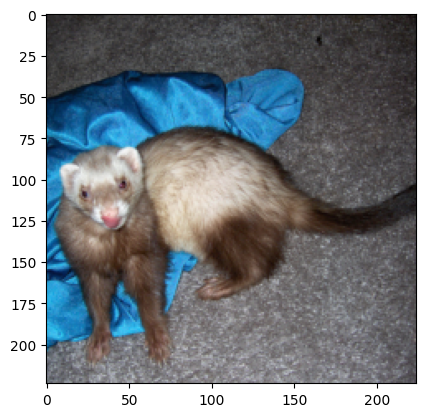

In [55]:
plt.imshow(convert_to_img(ferrot_tensor.squeeze(0)))

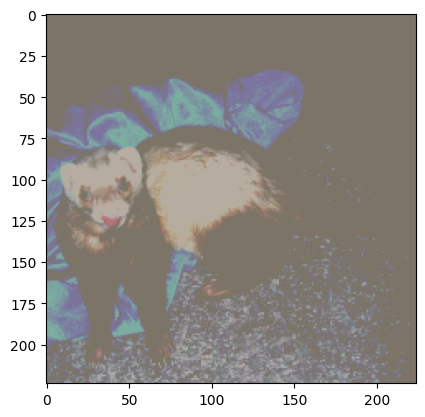

In [57]:
plt.imshow(convert_to_img(temp.squeeze(0)))

1.5089647769927979


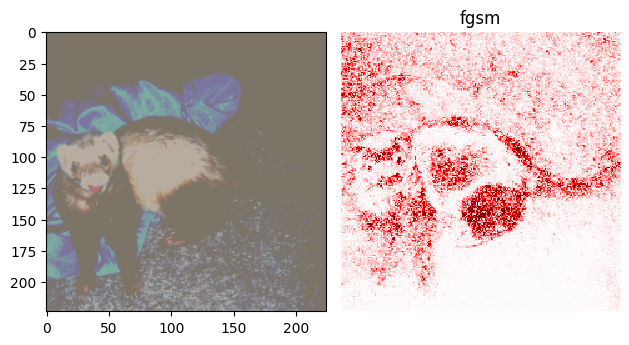

In [71]:
index = 0 
# x,y = valid_datasets[index]
x = ferrot_tensor
y = 359

start_time = time.time()


fig, axes = plt.subplots(1, 2) #, figsize=(2*len(names)//2, 2*2))
axes_flat = axes.flat 
my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))

ax = next(axes_flat)
ax.imshow(convert_to_img(temp.squeeze(0)))

attr = ig(model, x, y, temp.squeeze(0), device='cpu')
attr, kwargs  = process_heatmap(attr.cpu(), my_cmap)
ax = next(axes_flat)
ax.imshow(attr, **kwargs)
ax.set_title('fgsm')
ax.axis("off")
plt.tight_layout()

print(time.time() - start_time)

0.21243071556091309


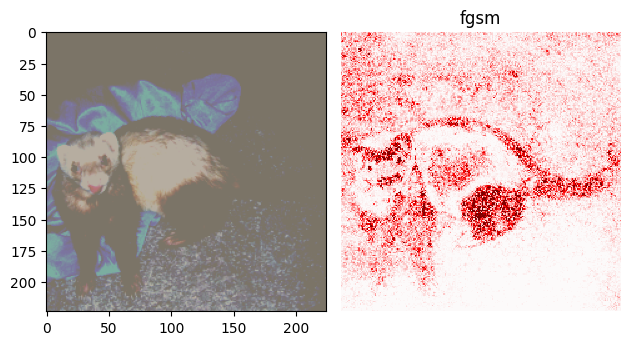

In [70]:
start_time = time.time()

fig, axes = plt.subplots(1, 2) #, figsize=(2*len(names)//2, 2*2))
axes_flat = axes.flat 
my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))

ax = next(axes_flat)
ax.imshow(convert_to_img(temp.squeeze(0)))

attr = ig(model, x, y, temp.squeeze(0), M = 1, device='cpu')
attr, kwargs  = process_heatmap(attr.cpu(), my_cmap)
ax = next(axes_flat)
ax.imshow(attr, **kwargs)
ax.set_title('fgsm')
ax.axis("off")
plt.tight_layout()

print(time.time() - start_time)

tensor(208)


<Axes: >

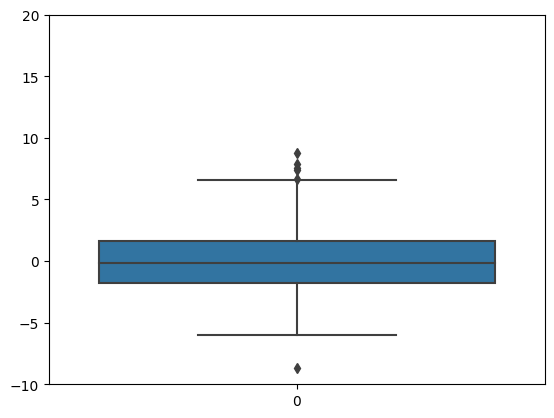

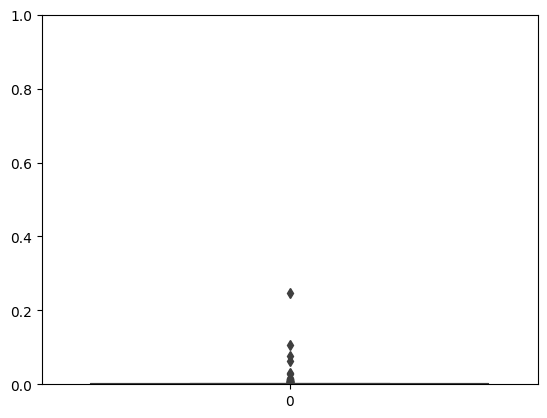

In [68]:
scr = model(temp)
m = nn.Softmax(dim=1)

sft = m(scr)
pre = torch.argmax(scr)
log = scr.detach().numpy()
lg = sft.detach().numpy()
print(pre)
plt.figure()
sns.boxplot(log)
plt.ylim(-10, 20)
plt.figure()
plt.ylim(0, 1)
sns.boxplot(lg)


torch.Size([1, 3, 224, 224])
tensor([[[[-6.3167e-05, -9.4625e-05, -3.6221e-05,  ..., -5.1914e-06,
            0.0000e+00,  0.0000e+00],
          [-3.7660e-05, -8.5611e-05, -4.6733e-05,  ..., -1.1200e-05,
            0.0000e+00,  0.0000e+00],
          [ 3.1547e-06,  2.1271e-05,  4.1787e-05,  ..., -5.0628e-06,
            0.0000e+00,  0.0000e+00],
          ...,
          [-3.2603e-06, -7.5018e-06,  2.8386e-06,  ..., -2.4139e-06,
           -9.5102e-06, -5.5576e-06],
          [ 1.5441e-06, -5.0939e-06, -1.1023e-05,  ...,  5.1804e-06,
            9.7590e-06,  4.6679e-06],
          [-2.4931e-06, -4.4798e-06, -3.9364e-06,  ...,  8.4647e-06,
            1.5777e-06, -1.6720e-06]],

         [[-1.2271e-04, -1.3712e-04, -4.5486e-05,  ...,  5.2795e-07,
            0.0000e+00,  0.0000e+00],
          [-9.5719e-05, -1.1494e-04, -2.8130e-05,  ...,  2.1981e-06,
            0.0000e+00,  0.0000e+00],
          [-5.3008e-05, -2.6156e-06,  5.2790e-05,  ...,  6.6056e-06,
            0.0000e+00,  0.00

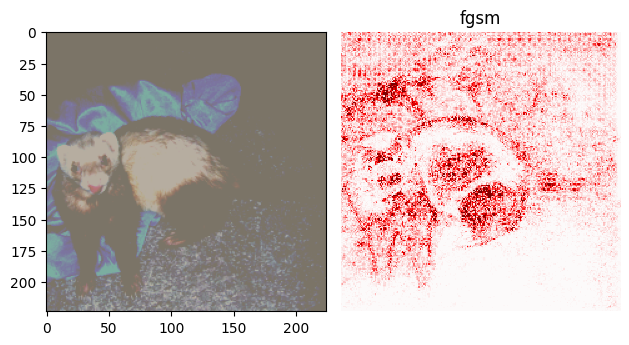

In [84]:
from torch.autograd import Variable

def make_interpolation(x, M, baseline):
    lst = [] 
    for i in range(M+1):
        # alpha = float(i/M)
        alpha = 0.  
        interpolated =x * (alpha) + baseline * (1-alpha)
        lst.append(interpolated.clone())
        break
    return torch.stack(lst)

def ig1(model, x, y, baseline, device='cuda:0', **kwrags):
    x = x.to(device)
    baseline = baseline.to(device)
    model.zero_grad()
    
    X = make_interpolation(x, 0, baseline)
    X = Variable(X, requires_grad=True).to(device)
    # X = baseline.deatch().clone().unsqueeze(0)
    X.retain_grad()
    
    output = model(X,)
    score = torch.softmax(output, dim=-1)
    class_score = torch.FloatTensor(X.size(0), output.size()[-1]).zero_().to(device).type(X.dtype)
    class_score[:,y] = score[:,y]
    output.backward(gradient=class_score)

    gradient = X.grad  #Approximate the integral using the trapezoidal rule
    print(gradient.size())
    # gradient = (gradient[:-1] + gradient[1:]) / 2.0
    print(gradient)
    output = (x - baseline) * gradient.mean(axis=0)
    # print(output)
    output = output.mean(dim=0) # RGB mean
    output = output.abs()
    return output

start_time = time.time()

fig, axes = plt.subplots(1, 2) #, figsize=(2*len(names)//2, 2*2))
axes_flat = axes.flat 
my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))

ax = next(axes_flat)
ax.imshow(convert_to_img(temp.squeeze(0)))

attr = ig1(model, x, y, temp.squeeze(0), device='cpu')
attr, kwargs  = process_heatmap(attr.cpu(), my_cmap)
ax = next(axes_flat)
ax.imshow(attr, **kwargs)
ax.set_title('fgsm')
ax.axis("off")
plt.tight_layout()

print(time.time() - start_time)